In [7]:
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

In this notebook we will train a convolutional architecture in Pytorch to label brain MRI images with a type of malignancy of types:

glioma - meningioma - notumor - pituitary

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from typing import List, Tuple

from dataclasses import dataclass
import matplotlib.pyplot as plt
import random

In [9]:
@dataclass
class BrainTumorDataset(Dataset):
    root_dir: str
    transform: transforms.Compose = None
    
    def __post_init__(self):
        self.image_paths: List[str] = []
        self.labels: List[int] = []
        self.label_map = {
            'glioma': 0,
            'meningioma': 1,
            'notumor': 2,
            'pituitary': 3
        }
        self.label_map_inv = {v: k for k, v in self.label_map.items()}
        self._load_data()
    
    def _load_data(self):
        for class_name, label in self.label_map.items():
            class_folder = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    image_path = os.path.join(class_folder, filename)
                    if os.path.isfile(image_path):
                        self.image_paths.append(image_path)
                        self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def plot_random_images(self, num_images=4):
        """Plot a random sample of images with their labels."""
        fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
        
        random_indices = random.sample(range(len(self)), num_images)
        
        for i, idx in enumerate(random_indices):
            image, label = self[idx]
            
            # Denormalize the image for visualization
            image = self.denormalize_image(image)
            
            ax = axes[i]
            ax.imshow(image.permute(1, 2, 0).clip(0, 1))  # Clip values to valid range
            ax.set_title(f"Label: {self.label_map_inv[label]}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def denormalize_image(image):
        """Denormalize the image for visualization."""
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return image * std + mean

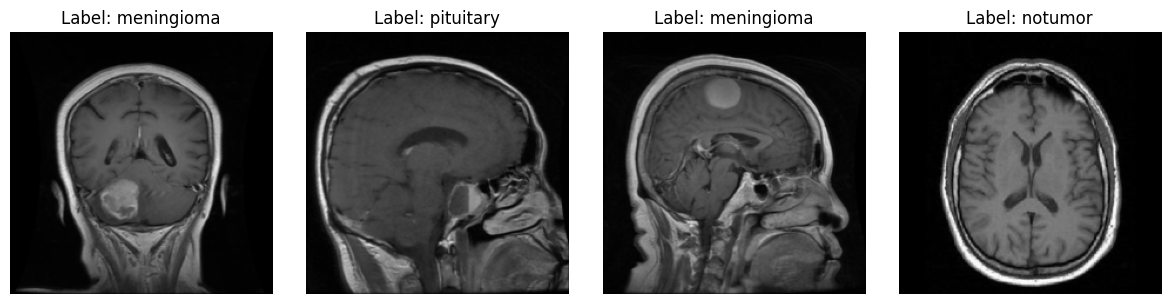

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize the image to a fixed size (224x224 for ResNet-18)
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(            # Normalize based on ImageNet stats (pre-trained model)
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

dataset = BrainTumorDataset(root_dir='data\\brain-tumor-mri-dataset/training', transform=transform)

train_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=4)

dataset.plot_random_images(num_images=4)

The problem of detecting (the type of) tumor may be rather complex for a computer. In a regular MRI photo, many features are shown, such as the folds in the brain, eyes, facial features, etc. It has to distinguish these from a tumor. Due to this complexity, a deeper neural network is expected. 

Deeper networks pair with vanishing and exploding gradients, therefore, we will use batch normalisation and residual layers. Larger convolutional kernels are also expected to be necessary.

An other route to take is to take a pretrained network such as resnet and finetune this network to detect the type of tumor. This we will do first and then see if this model can be beaten (most likely not due to limitations of computational resources)

In [11]:
class BrainTumorClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        in_features = self.model.fc.in_features

        # Freezing all weights of resnet18
        for param in self.model.parameters():
            param.requires_grad = False
        
        # self.classifier = nn.Sequential(
        #     nn.Linear(in_features, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 4)
        # )

        self.classifier = nn.Sequential( # Test with a very simple added sequence of layers, see how fast this is.
            nn.Identity(),
            nn.ReLU(),
            nn.Linear(in_features, 4)
        )
    
    def forward(self, x):
        y = self.model(x)
        logits = self.classifier(y)
        return logits

In [ ]:
model = BrainTumorClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

num_epochs = 3
for epoch in range(num_epochs):
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    model.train()

    for inputs, labels in train_loader: 
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

c:\Users\gouwenss\miniconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gouwenss\miniconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Example of a residual block.

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out += self.shortcut(x)  
        return out